# Analytics

#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- 16/0142628	Rafaella Junqueira
- 17/0017885	Marcos Nery
- 16/0130883	Larissa Sales
- 17/0035158	Gustavo Marques
- 20/0073249	Pedro Vitor Augusto de Jesus
- 18/0119508	Eric Chagas de Oliveira
- 13/0111147	Gabriel do Nascimento de Carvalho
- 20/0019228	Gustavo Martins Ribeiro
- 19/0096373	Vinícius Alves de Sousa
- 19/0014776	Israel Thalles Dutra dos Santos
- 19/0055006	Gian Medeiros Rosa

### LIBRARIES

In [1]:
%pip install pandas
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [216]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [217]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [218]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [219]:
jsons = glob('../analytics-raw-data/*/*.json', recursive=True) # add your path here
len(jsons)

17

In [220]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

#### Create base component dataframe

#### Create dataframe per file

In [221]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [222]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        file_component_df_ts = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)
        file_component_df_ts['filename']= os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        df = df.append(file_component_df_ts, ignore_index=True)
        
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-Cartografia-social-(.*?)-[0-9]+-(.*?)-v(.*?).json", expand=True)  

    df['Repository'] = aux_df[1]

    df['Version'] = aux_df[3]
    
    df['Date'] = aux_df[2]

    df = df.sort_values(by=['Repository', 'Version'])

    return df

In [223]:
file_component_df = create_file_df(jsons)
file_component_df.Repository.unique()

/tmp/ipykernel_66/3909151359.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_66/3909151359.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df_ts, ignore_index=True)
/tmp/ipykernel_66/3909151359.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_66/3909151359.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df_ts, ignore_index=True)
/tmp/ipykernel_66/3909151359.py:45: FutureWarning: The frame.append method is deprecated and will 

array(['api-comunidades', 'api-gateway', 'api-mapas', 'api-midia',
       'api-users', 'front'], dtype=object)

#### Create dataframe per repository

In [224]:
api_comunidades_df = file_component_df[file_component_df['Repository'] == 'api-comunidades']
api_gateway_df = file_component_df[file_component_df['Repository'] == 'api-gateway']
api_mapas_df = file_component_df[file_component_df['Repository'] == 'api-mapas']
api_midia_df = file_component_df[file_component_df['Repository'] == 'api-midia']
api_users_df = file_component_df[file_component_df['Repository'] == 'api-users']
front_df = file_component_df[file_component_df['Repository'] == 'front']

In [225]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [226]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [227]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [228]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Test coverage

In [229]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3 and m6 for each repository

In [230]:
def create_metrics_df(df):
    
    version_vec = df['Version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    dates_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['Version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['Repository'].iloc[0])
        dates_list.append(version_df['Date'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm6': m6_list,
                               'LOC': ncloc_list,
                               'Repository': repository_list, 
                               'Version': version_list,
                               'Date': dates_list
                               })
        
    return metrics_df

In [231]:
api_gateway_metrics = create_metrics_df(api_gateway_df)
front_metrics = create_metrics_df(front_df)
api_comunidades_metrics = create_metrics_df(api_comunidades_df)
api_mapas_metrics = create_metrics_df(api_mapas_df)
api_midia_metrics = create_metrics_df(api_midia_df)
api_users_metrics = create_metrics_df(api_users_df)


### Sub characteristic aggregation



In [232]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm6 = 0.7

def add_remaining_measurements(repo_metrics_df):
    repo_metrics_df['code_quality'] = ((repo_metrics_df['m1']*pm1) + (repo_metrics_df['m2']*pm2) + (repo_metrics_df['m3']*pm3)) * psc1
    repo_metrics_df['testing_status'] = ((repo_metrics_df['m6']*pm6)) * psc2
    repo_metrics_df['Maintainability'] = repo_metrics_df['code_quality'] * pc1
    repo_metrics_df['Reliability'] = repo_metrics_df['testing_status'] * pc2
    repo_metrics_df['Total_QR'] = repo_metrics_df['Maintainability'] + repo_metrics_df['Reliability']

all_repo_measurements = [
    api_gateway_metrics,
    front_metrics,
    api_comunidades_metrics,
    api_mapas_metrics,
    api_midia_metrics,
    api_users_metrics
]    
for repo in all_repo_measurements:
    add_remaining_measurements(repo)
    repo_name = repo['Repository'].iloc[0]

In [233]:
central_tendency_indicators = pd.DataFrame(columns=['Média', 'Moda', 'Mediana', 'DesvioPadrão', 'Variância', 'Minínimo', 'Máximo'])
central_tendency_indicators.loc['Reliability'] = [
    front_metrics['Reliability'].mean(),
    list(front_metrics['Reliability'].mode()),
    front_metrics['Reliability'].median(),
    front_metrics['Reliability'].std(),
    front_metrics['Reliability'].var(),
    front_metrics['Reliability'].min(),
    front_metrics['Reliability'].max()
]
central_tendency_indicators.loc['Maintainability'] = [
    front_metrics['Maintainability'].mean(),
    list(front_metrics['Maintainability'].mode()),
    front_metrics['Maintainability'].median(),
    front_metrics['Maintainability'].std(),
    front_metrics['Maintainability'].var(),
    front_metrics['Maintainability'].min(),
    front_metrics['Maintainability'].max()
]
central_tendency_indicators

,Média,Moda,Mediana,DesvioPadrão,Variância,Minínimo,Máximo
Reliability,0.001754,[0.0],0.000000,0.004642,0.000022,0.000000,0.012281
Maintainability,0.273230,[0.275],0.274455,0.002277,0.000005,0.269554,0.275000


(0.25, 0.28)

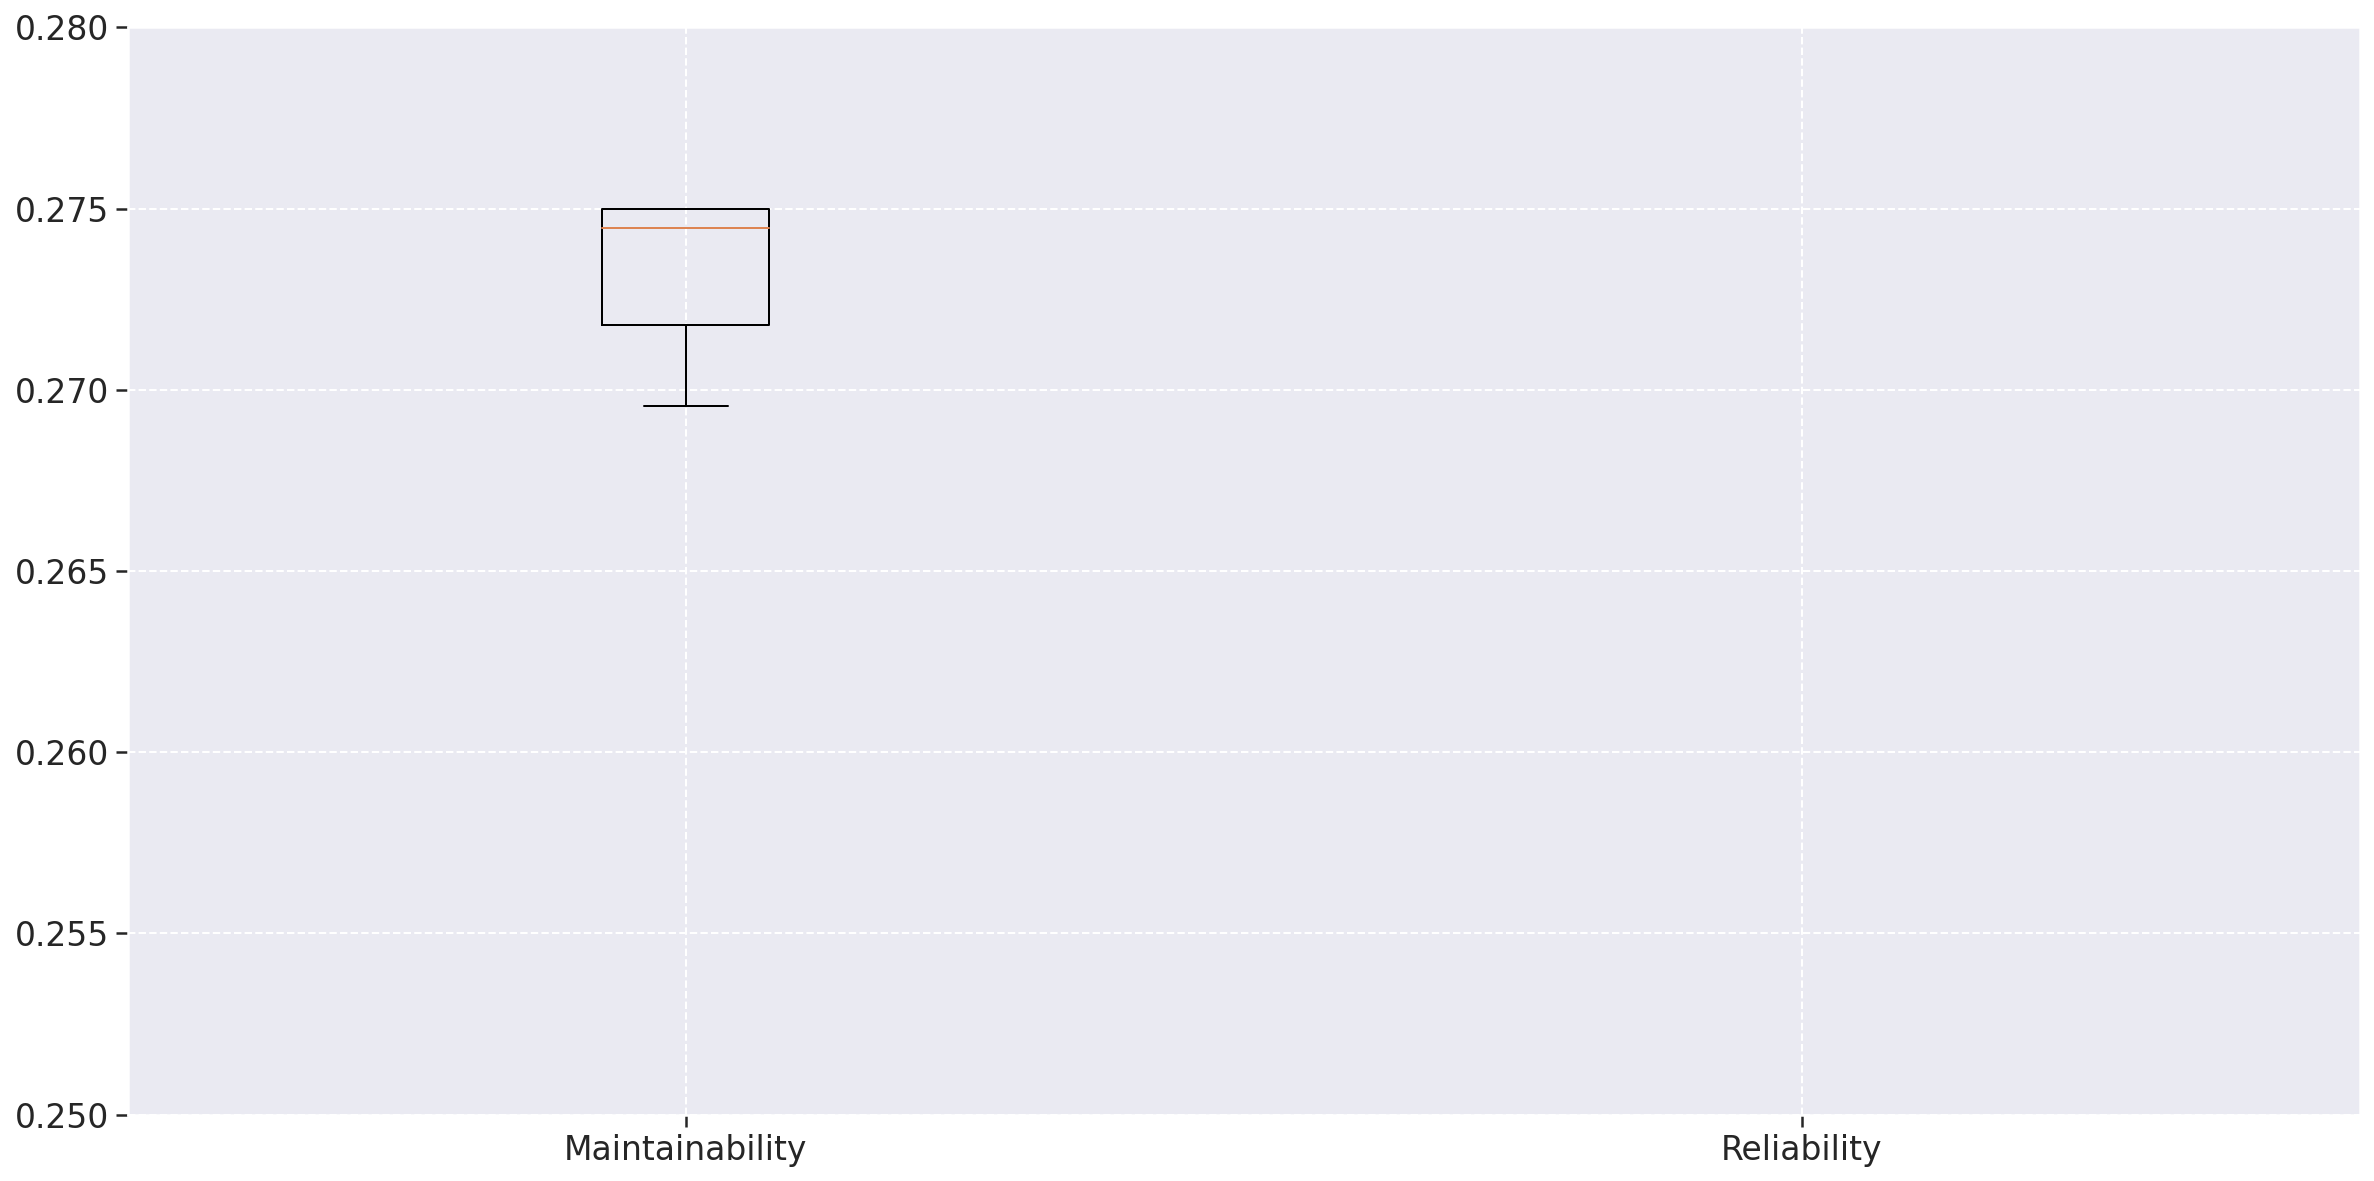

In [239]:
fig = plt.figure(figsize=(20, 10))


plt.boxplot([front_metrics['Maintainability'], front_metrics['Reliability']], labels=['Maintainability','Reliability'])
plt.ylim(.25,.28)


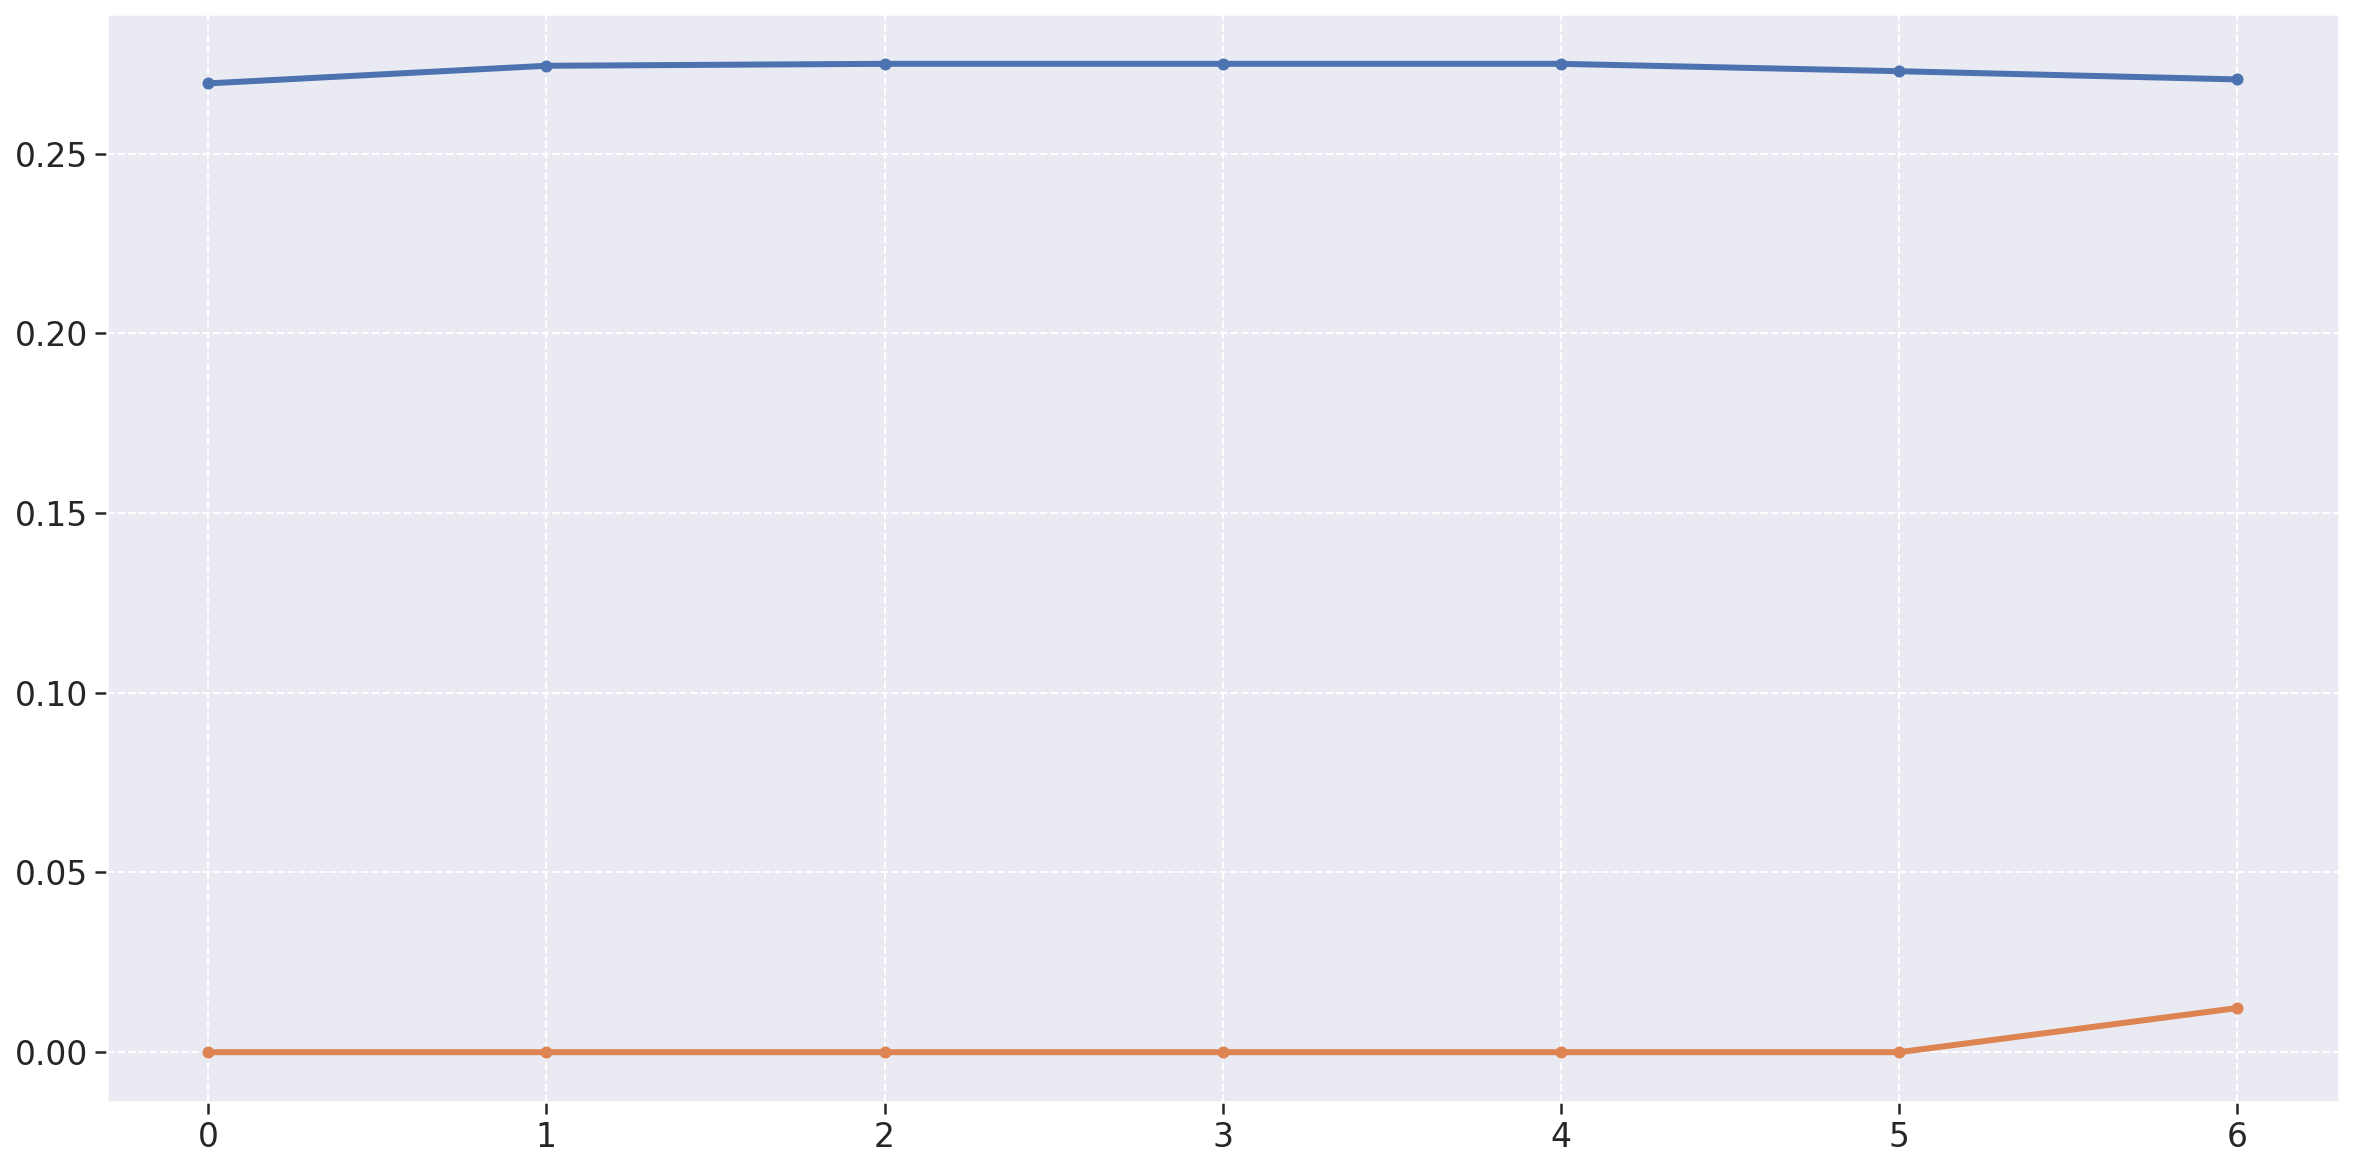

In [235]:
fig = plt.figure(figsize=(20, 10))

plt.plot(front_metrics['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(front_metrics['Reliability'], linewidth=3, marker='o', markersize=5)

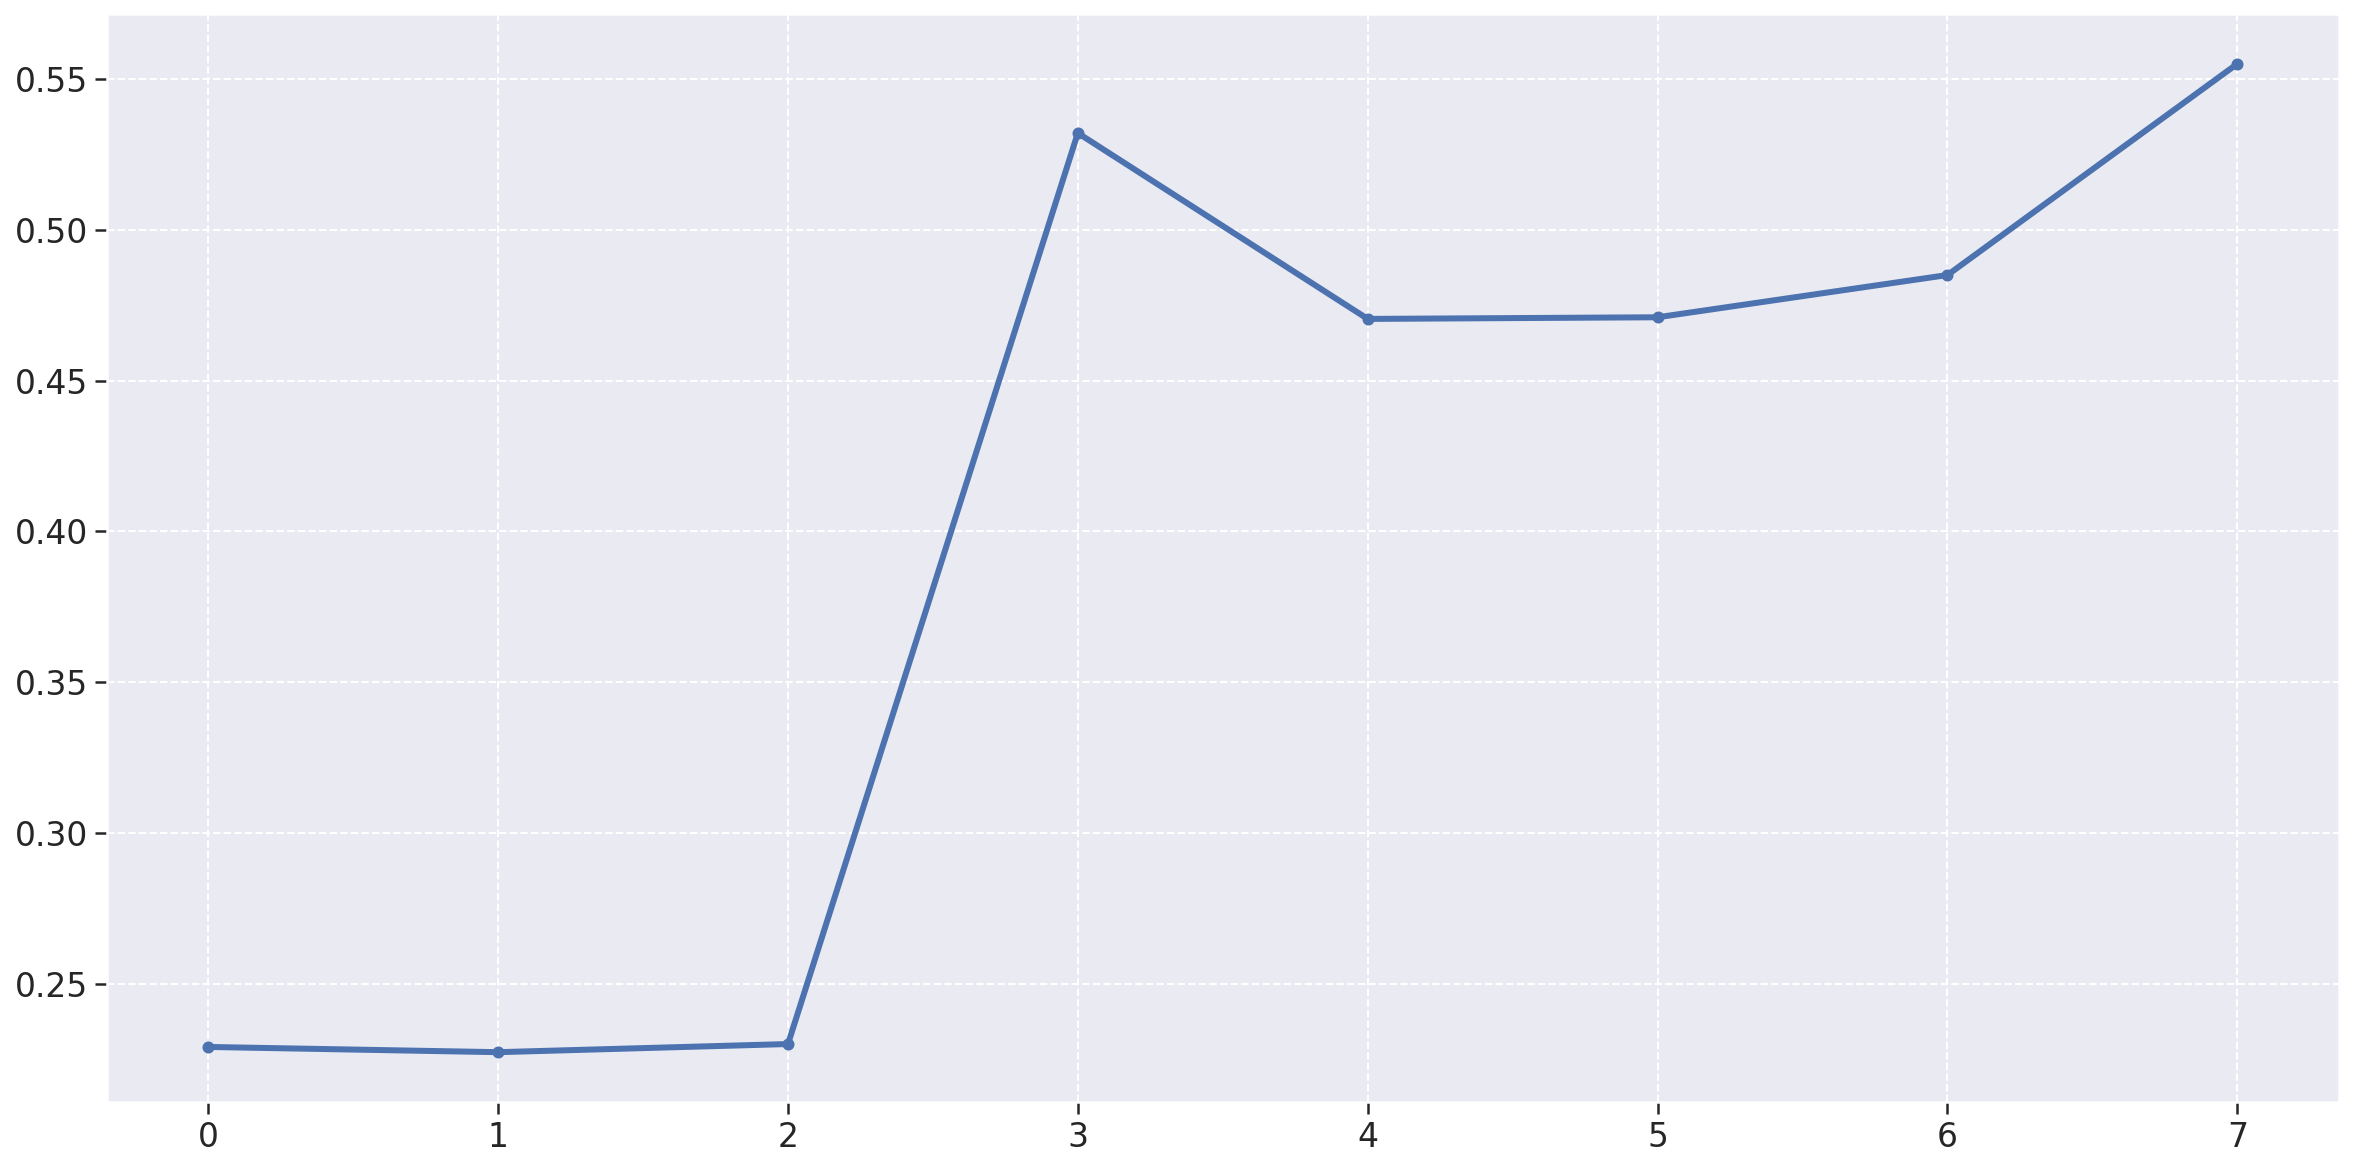

In [236]:
total_metrics_df = pd.concat(all_repo_measurements, ignore_index=True)
total_metrics_df['Maintainability'] = total_metrics_df['code_quality'] * pc1
total_metrics_df['Reliability'] = total_metrics_df['testing_status'] * pc2
total_metrics_df['Total_QR'] = total_metrics_df['Maintainability'] + metrics_df['Reliability']


fig = plt.figure(figsize=(20, 10))
plt.plot(total_metrics_df['Total_QR'], linewidth=3, marker='o', markersize=5)


In [237]:
def drop_unecessary(repo_metrics_df):
    repo_metrics_df.drop('code_quality', axis=1, inplace=True, errors='ignore')
    repo_metrics_df.drop('testing_status', axis=1, inplace=True, errors='ignore')

currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")
for repo in all_repo_measurements:
    drop_unecessary(repo)
    repo_name = repo['Repository'].iloc[0]
    repo.to_excel('data/fga-eps-mds-2021-2-Cartografia-social-{}-{}.xlsx'.format(repo_name,currentDateTime), index = False)
    repo.to_csv('data/fga-eps-mds-2021-2-Cartografia-social-{}-{}.csv'.format(repo_name,currentDateTime), index = False)